## 3.4 영화리뷰 분류 : 이진 준류 예제
### 3.4.1 IMDB 데이터셋
인터넷 영화 데이터베이스로부터 가져온 양극단의 리뷰 5만개로 이루어짐. 훈련 데이터 25,000개, 테스트 데이터 25,000개 각각 부정, 긍정 50%로 구성되어 있음.

In [1]:
from keras.datasets import imdb

# num_words : 빈도가 많은 순으로 1~10만번째 단어만 사용함을 의미
# 레이블 0은 부정, 1은 긍정
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

Using TensorFlow backend.


In [2]:
# index는 빈도 순위를 의미하므로 num_words 설정을 넘지 않음
max([max(seq) for seq in train_data])

9999

In [3]:
# 원래 단어로 변환
word_index = imdb.get_word_index()
reverse_word_index = dict([value, key] for (key, value) in word_index.items())
decoded_review = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[0]]) # 0, 1, 2는 패딩, 문서시작, 사전에 없음을 위한 인덱스이므로 3을 뺌
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

### 3.4.2 데이터 준비
리스트의 길이가 요소마다 다르므로 리스트의 텐서 전환이 필요하며 2가지 방법이 있음.
+ 같은 길이가 되도록 리스트에 패딩을 추가하고 (samples, sequence_length) 크기의 정수 텐서로 변환
+ 리스트를 원-핫 인코딩(one-hot encoding)하여 0과 1의 벡터로 변환

아래는 2번째 방법을 사용하였음.

In [4]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    result = np.zeros((len(sequences), dimension))
    for i, seq in enumerate(sequences):
        result[i, seq] = 1. # numpy는 여러 요소를 한번에 1로 바꿀 수 있음
    return result

x_train = vectorize_sequences(train_data)
x_test  = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32') # array와 차이점은 copy를 하지 않는다는 것
y_test = np.asarray(test_labels).astype('float32') 

### 3.4.3 신경만 모델 만들기
아래 구조의 신경망 모델을 생성.
+ 16개의 은닉 유닛을 가진 2개의 은닉 층
+ 현재 리뷰의 감정을 스칼라 값의 예측으로 출력하는 세 번째 층

In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [6]:
from keras import optimizers
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.0005),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

# 문자열로도 표현 가능
# model.complie(optimizer='rmsprop', 
#               loss='binary_crossentropy',
#               metrics=['accuracy'])


### 3.4.4 훈련 검증
10,000의 샘플을 떼어 검증 세트를 만듦.

In [7]:
# 검증 데이터 구분
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [8]:
# 모델 훈련하기
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

result = model.evaluate(x_test, y_test)
print(result) 

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 137us/step - loss: 0.5728 - binary_accuracy: 0.7677 - val_loss: 0.4750 - val_binary_accuracy: 0.8365
Epoch 2/20
15000/15000 [==============================] - 1s 80us/step - loss: 0.3927 - binary_accuracy: 0.8841 - val_loss: 0.3686 - val_binary_accuracy: 0.8760
Epoch 3/20
15000/15000 [==============================] - 1s 80us/step - loss: 0.2969 - binary_accuracy: 0.9095 - val_loss: 0.3214 - val_binary_accuracy: 0.8794
Epoch 4/20
15000/15000 [==============================] - 1s 66us/step - loss: 0.2384 - binary_accuracy: 0.9259 - val_loss: 0.2923 - val_binary_accuracy: 0.8870
Epoch 5/20
15000/15000 [==============================] - 1s 68us/step - loss: 0.1984 - binary_accuracy: 0.9390 - val_loss: 0.2802 - val_binary_accuracy: 0.8885
Epoch 6/20
15000/15000 [==============================] - 1s 78us/step - loss: 0.1690 - binary_accuracy: 0.9477 - val_loss: 0.2744 - val_binary_

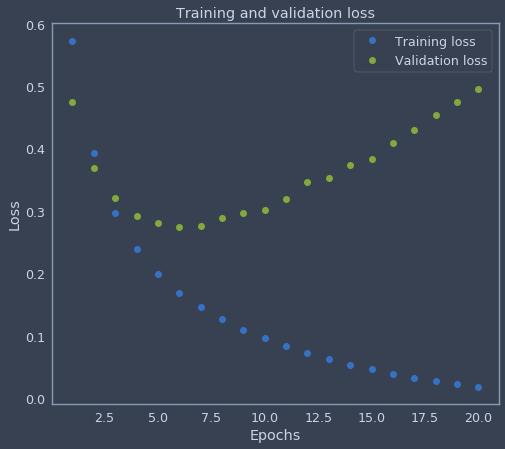

In [9]:
# 훈련과 검증 손실
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='oceans16', context='notebook', ticks=False, grid=False)

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'o', label='Training loss')
plt.plot(epochs, val_loss, 'o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show() # 7번째부터 Validation과 Training의 방향이 역전됨

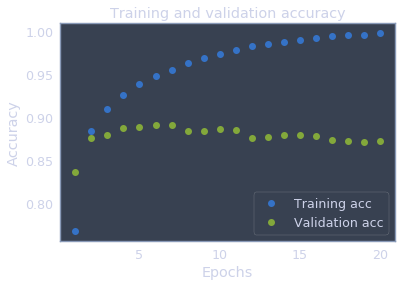

In [10]:
# 훈련과 검증 정확도
plt.clf()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'o', label='Training acc')
plt.plot(epochs, val_acc, 'o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show() # 7번째부터 Validation의 acc가 상승되지 않음

In [11]:
# 과적합을 막기 위해 epoch를 7로 제한
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=7,
                    batch_size=512,
                    validation_data=(x_val, y_val))

result = model.evaluate(x_test, y_test)
print(result)

Train on 15000 samples, validate on 10000 samples
Epoch 1/7
15000/15000 [==============================] - 1s 82us/step - loss: 0.0151 - binary_accuracy: 0.9987 - val_loss: 0.5213 - val_binary_accuracy: 0.8706
Epoch 2/7
15000/15000 [==============================] - 1s 83us/step - loss: 0.0128 - binary_accuracy: 0.9991 - val_loss: 0.5473 - val_binary_accuracy: 0.8705
Epoch 3/7
15000/15000 [==============================] - 1s 80us/step - loss: 0.0099 - binary_accuracy: 0.9995 - val_loss: 0.5768 - val_binary_accuracy: 0.8678
Epoch 4/7
15000/15000 [==============================] - 1s 81us/step - loss: 0.0081 - binary_accuracy: 0.9995 - val_loss: 0.6080 - val_binary_accuracy: 0.8680
Epoch 5/7
15000/15000 [==============================] - 1s 83us/step - loss: 0.0060 - binary_accuracy: 0.9998 - val_loss: 0.6485 - val_binary_accuracy: 0.8636
Epoch 6/7
15000/15000 [==============================] - 1s 83us/step - loss: 0.0050 - binary_accuracy: 0.9998 - val_loss: 0.6679 - val_binary_accurac

## 3.5 뉴스기사 분류 : 다중 분류 문제
### 3.5.1 로이터 데이터셋
46개의 토픽이 있으며 어떤 토픽은 다른 것에 비해 데이터가 많고 최소 10개의 샘플이 있음. 훈련 샘플은 8,982개, 테스트 샘플은 2,246개.

In [12]:
from keras.datasets import reuters

# num_words : 빈도가 많은 순으로 1~10만번째 단어만 사용함을 의미
# 일반적으로는 훈련 데이터에서 구축한 어휘 사전으로 테스트 세트를 변환(테스트 세트의 어휘를 학습하지 않게 하기 위해)
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
                                                                         
# 원래 단어로 변환
word_index = reuters.get_word_index()
reverse_word_index = dict([value, key] for (key, value) in word_index.items())
decoded_review = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[0]]) # 0, 1, 2는 패딩, 문서시작, 사전에 없음을 위한 인덱스이므로 3을 뺌
decoded_review

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

### 3.5.2 데이터 준비
One-hot 인코딩을 사용하여 레이블 데이터 변경. 내장함수를 사용하는 방식은 하단부 주석을 참고.

In [13]:
import numpy as np

# 입력 데이터
def vectorize_sequences(sequences, dimension=10000):
    result = np.zeros((len(sequences), dimension))
    for i, seq in enumerate(sequences):
        result[i, seq] = 1. # numpy는 여러 요소를 한번에 1로 바꿀 수 있음
    return result

x_train = vectorize_sequences(train_data)
x_test  = vectorize_sequences(test_data)

# 레이블 데이터
def to_one_hot(labels, dimension=46):
    result = np.zeros((len(labels), dimension))
    for i, l in enumerate(labels):
        result[i, l] = 1. # numpy는 여러 요소를 한번에 1로 바꿀 수 있음
    return result

onehot_train_labels = to_one_hot(train_labels)
onehot_test_labels  = to_one_hot(test_labels)

# 내장함수를 사용하는 경우
# from keras.utils.np_utils import to_categorical
# onehot_train_labels = to_categorical(train_labels)
# onehot_test_labels  = to_categorical(test_labels)

### 3.5.3 모델 구성
IMDB 데이터셋 대비 많은 46개의 클래스를 구분하기 충분한 Weight 개수로 구성 필요

In [14]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax')) # 다중 클래스 구분에 사용

model.compile(optimizer='rmsprop',             # Learning Rate는 기본값
              loss='categorical_crossentropy', # 모델이 출력한 확률분포와 실 레이블의 분포 사이의 거리
              metrics=['accuracy'])

### 3.5.4 훈련 검증
훈련 데이터에서 1,000개의 샘플을 따로 떼어서 검증 세트로 사용.

In [15]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = onehot_train_labels[:1000]
partial_y_train = onehot_train_labels[1000:]

In [16]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 83us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 0s 57us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 0s 56us/step - loss: 1.0953 - acc: 0.7651 - val_loss: 1.1708 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 0s 57us/step - loss: 0.8697 - acc: 0.8165 - val_loss: 1.0793 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 0s 56us/step - loss: 0.7034 - acc: 0.8472 - val_loss: 0.9844 - val_acc: 0.7810
Epoch 6/20
7982/7982 [==============================] - 0s 56us/step - loss: 0.5667 - acc: 0.8802 - val_loss: 0.9411 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 0s 54us/step - loss: 0.4581 - acc: 0.9048 - val_loss: 0.9083 - val_acc: 0.8020
Epoch 8

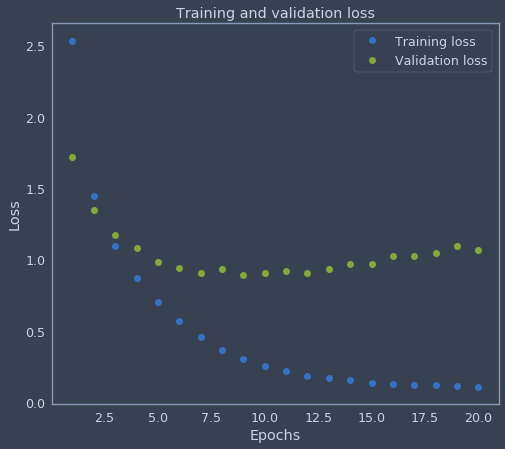

In [17]:
# 훈련과 검증 손실
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='oceans16', context='notebook', ticks=False, grid=False)

plt.clf()

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'o', label='Training loss')
plt.plot(epochs, val_loss, 'o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show() # 7번째부터 Validation과 Training의 방향이 역전됨

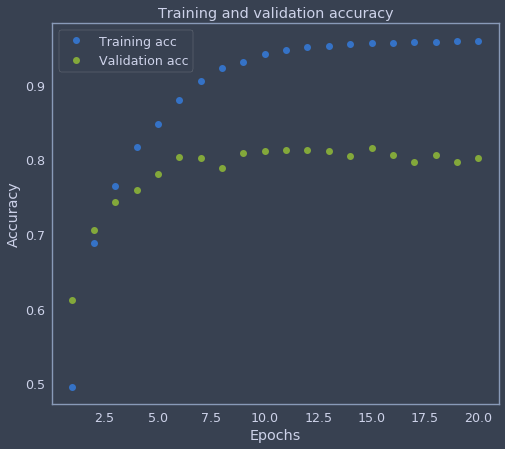

In [18]:
# 훈련과 검증 정확도
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'o', label='Training acc')
plt.plot(epochs, val_acc, 'o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show() # 7번째부터 Validation의 acc가 상승되지 않음

In [19]:
# 적절한 epoch를 반영하여 모델을 재학습
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax')) # 다중 클래스 구분에 사용

model.compile(optimizer='rmsprop',             # Learning Rate는 기본값
              loss='categorical_crossentropy', # 모델이 출력한 확률분포와 실 레이블의 분포 사이의 거리
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))

results = model.evaluate(x_test, onehot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 76us/step - loss: 2.5398 - acc: 0.5226 - val_loss: 1.6733 - val_acc: 0.6570
Epoch 2/9
7982/7982 [==============================] - 0s 54us/step - loss: 1.3712 - acc: 0.7121 - val_loss: 1.2758 - val_acc: 0.7210
Epoch 3/9
7982/7982 [==============================] - 0s 56us/step - loss: 1.0136 - acc: 0.7781 - val_loss: 1.1303 - val_acc: 0.7530
Epoch 4/9
7982/7982 [==============================] - 0s 54us/step - loss: 0.7976 - acc: 0.8251 - val_loss: 1.0539 - val_acc: 0.7590
Epoch 5/9
7982/7982 [==============================] - 0s 60us/step - loss: 0.6393 - acc: 0.8624 - val_loss: 0.9754 - val_acc: 0.7920
Epoch 6/9
7982/7982 [==============================] - 0s 58us/step - loss: 0.5124 - acc: 0.8921 - val_loss: 0.9102 - val_acc: 0.8140
Epoch 7/9
7982/7982 [==============================] - 0s 56us/step - loss: 0.4124 - acc: 0.9139 - val_loss: 0.8932 - val_acc: 0.8210
Epoch 8/9
7982

In [20]:
print(model.metrics_names)
print(result) # 85%의 정확도

['loss', 'acc']
[0.7607454730439186, 0.85212]


### 3.5.5 새로운 데이터에 대해 예측하기
predictions의 각 항목 길이는 46인 벡터이며 백터의 원소합은 1. 이 중 가장 큰 값이 예측 클래스가 

In [21]:
predictions = model.predict(x_test)
predictions[0].shape

(46,)

In [22]:
np.sum(predictions[0])

0.99999976

In [23]:
np.argmax(predictions[0]) # 클래스가 3임

3

### 3.5.6 레이블과 손실을 다루는 다른 방법
정수 텐서로 변환하고 손실 함수를 sparse_categorical_crossentropy로 변환하면 수학적으로 categorical_crossentropy와 동일.

    y_train = np.array(train_labels)
    y_test = np.array(test_labels)
    ...
    model.compile(optimizer='rmsprop',
                  loss=sparse_categorical_crossentropy
                  metrics=['acc']) 

### 3.5.9 정리
+ loss는 범주형 크로스엔트로피를 사용
+ 레이블을 다루는 2가지 방법
    + 레이블을 범주형 인코딩(또는 원-핫 인코딩)하고 categorical_crossentropy 손실 함수를 사용
    + 레이블을 정수로 인코딩하고 sparse_categorical_crossentropy 손실 함수를 사용

## 3.6 주택 가격 예측: 회귀문제
### 3.6.1 보스턴 주택 가격 데이터셋
1970년 중반 보스턴 외곽 지역의 범죄율, 지방세율 등의 데이터가 주어졌을 때 주택 가격의 중간 값을 예측하는 문제.
데이터 포인트는 506개, 이 중 404개는 훈련 샘플, 102개는 테스트 샘플로 나뉘어 있음. 타깃은 주택의 중간 가격으로 천 달러 단위임.

In [25]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
print("train & test data shapes", train_data.shape, test_data.shape)
print("traget", train_targets[:6])

train & test data shapes (404, 13) (102, 13)
traget [15.2 42.3 50.  21.1 17.7 18.5]


### 3.6.2 데이터 준비
특성의 스케일이 다르면 전역 최소 점을 찾아가는 경사 하강법의 경로가 스케일 큰 특성에 영향을 많이 받기 때문에 정규화를 적용

In [26]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean # 머신러닝 작업과정에서 절대로 테스트 데이터에서 계산한 
test_data /= std  # 어떤 값도 사용해서는 안됨

### 3.6.3 모델 구성
샘플 개수가 적기 때문에 과대 적합을 피할 수 있도록 2개 은닉 층으로 구성된 작은 네크워크를 사용
+ 회귀 문제기 때문에 마지막 레이어는 하나의 유닛을 가지고 활성화 함수가 없음
+ 손실함수는 평균 제곱 오차(mean squared error), 회귀 문제에서 널리 사용됨
+ 훈련 모니터링을 위해 평균 절대 오차(mean absolute error)를 측정

In [27]:
from keras import models
from keras import layers

def build_model(): # 동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model            

### 3.6.4 K-겹 검증을 사용한 훈련 검증
데이터가 많지 않기 때문에 훈련 데이터와 테스트 데이터를 교차 분할하여 사용하는 K-겹 교차 검증을 사용함

In [28]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print("처리중인 폴드 #", i)
    
    # 검증 데이터 준비
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    # 훈련 데이터 준비
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i+1)*num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], train_targets[(i+1)*num_val_samples:]],
        axis=0
    )
    
    model = build_model()
    hist = model.fit(partial_train_data, partial_train_targets,
                     validation_data=(val_data, val_targets),
                     epochs=num_epochs, batch_size=1,
                     verbose=0) # verbose=0이면 미ㅣ훈련 과정이 출력되지 않음
    mae_hist = hist.history['val_mean_absolute_error']
    all_mae_histories.append(mae_hist)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [29]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories])
    for i in range(num_epochs) # 각 폴드를 순회하면서 epochs별 평균값을 구함
]

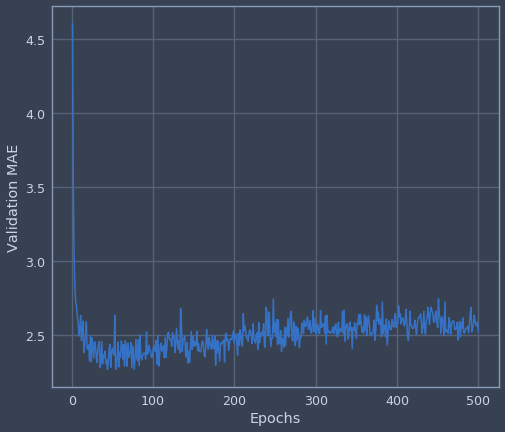

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='oceans16', context='notebook')

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Text(0, 0.5, 'Validation MAE')

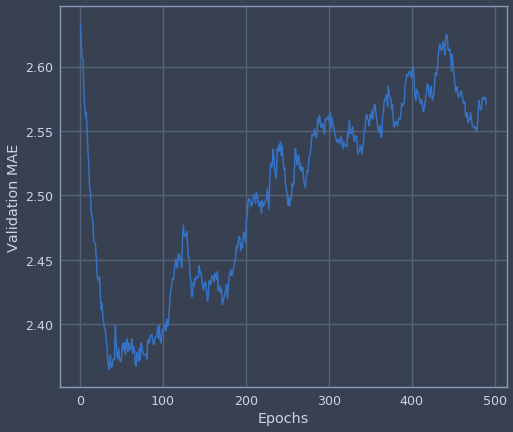

In [31]:
# 그래프의 변동이 심하기 때문에 지수 이동평균으로 대체
def smooth_curve(points, factor=0.9):
    smoothed_points=[]
    
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
            
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

In [32]:
# 최종 모델 훈련
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=10, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 669us/step


In [33]:
test_mae_score # 테스트 데이터를 통한 평가결과 약 2,600달러 차이가 발생

2.7772768899506213

## 3.6.5 정리
+ 회귀는 분류와는 다르게 평균 제곱 오차를 손실 함수로 자주 사용
+ 일반적인 회귀 지표는 평균 절대 오차
+ 가용 데이터가 적다면 K-겹 검증을 사용
+ 가용 데이터가 적다면 과대적합을 피하기 위해 은닉 층의 수를 적게 사용